 # **<center>  Lab 5- Space-variant Blurring** </center> 
### **Problem Statement:**

1. Space-variant Blurring Now assume the blur to be space-variant, i.e. the standard deviation varies for each pixel. Consider the distribution of σ to be
$ σ(m, n) = A e^\frac {-((m − \frac{N}{2})^2 +(n − \frac{N}{2})^2)}{B}
 , 0 ≤ m, n ≤ N − 1$

  with $σ( \frac{N}{2} , \frac{N}{2})= 2.0 $ and $σ(0, 0) = 0.01,$

  where N × N is size of the image and pixel indices are in the range [0, N − 1] × [0, N − 1]. Find
A and B, and create the matrix σ. Perform Gaussian blurring on Globe.pgm using the values
of σ(m, n).


2. Blur Nautilus.pgm using

  (a) space-invariant blur code of part 1 with σ = 1.0, and
  
  (b) space-variant blur code of part 2 with σ(m, n) = 1.0 for 0 ≤ m, n ≤ N − 1.
Verify that the blurred images of the above two steps are same.

### 1. Importing required Libraries and Reading the image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

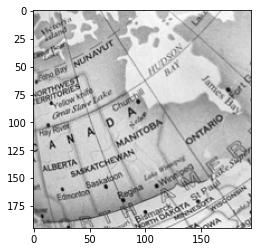

In [ ]:
globe=imread('Globe.png')
plt.imshow(globe,'gray')

###2. Function for Determining Kernel size
Given a value of $\sigma$ the function returns the value of the width (or size) of blur kernel.

In [ ]:
def get_kernel_sizes(sigma):
    # choose the window size to be the
    # smallest odd integer greater than
    # or equal to 6*sigma +1 
    w = np.ceil(6*sigma+1)
    try:
        # when sigma is an array/matrix
        w[w % 2 == 0]+=1
        return w.astype(np.int)
    except:
        # when sigma is a single value
        if w % 2 == 0:
            w += 1
        return int(w)

###3. Function for Formation of Blur Kernel
Given the value of $\sigma$ and the kernel width (or size) the function returns a gaussian blur kernel of size as specified by kernel width.

In [ ]:
def form_blur_kernel(w, sigma):
    d = w//2
    # blur kernel of the required size
    blur_kernel = np.zeros((w, w))
    if w == 1:
        return np.ones((w, w))
    for i in range(w):
        for j in range(w):
            # As defined in class
            # skipping the 1/(2*np.pi*sigma**2) constant as it will cancel
            # out anyways in the sum and calculating it again and again is
            # just useless computation
            blur_kernel[i, j] = np.exp((-(i-d)**2-(j-d)**2)/(2*(sigma**2)))
    # divide by the sum of the entries so that the entries of the kernel
    # sum up to 1. This is necessary to ensure that we do not dim or brighten
    # the image we are convolving
    blur_kernel = blur_kernel/np.sum(blur_kernel)
    return blur_kernel

###4. Function for Preparation of the image
Given the image and the kernel width (or size of blur kernel)  this function performs padding on the image so that the blur kernel sits properly on the image and after convolution the output image is of the same size as that of input image.

Padding can be done in two types:


*   Zero padding (filling the outer rows by zeros)
*   Extension (filling of the outer rows with pixels similar to the pixels in the image)

Here, we are using zero padding.



In [ ]:
def zero_pad_image(image, w):
    # get the shape of the image
    [x, y] = np.shape(image)
    # how much to zero pad by to maintain the shape
    d = w//2
    # array of zeros
    zero_padded_image = np.zeros((x+2*d, y+2*d))
    # fill the middle of it with the given image
    zero_padded_image[d:-d, d:-d] = image
    return zero_padded_image

###5. Function for formation of sigma matrix 
Forming a sigma matrix by using the given equation for variation of $ \sigma$

In [ ]:
def get_A_B(N, s_0, s_N_by_2):
    A = s_N_by_2
    B = N**2/(2*np.log(A/s_0))
    return A, B

In [ ]:
def sigma_mat(A, B, N):
    a = np.arange(N)
    # use meshgrid to avoid double for loops
    [x,y] = np.meshgrid(a,a)
    # The equivalent code using double for loops is
    # final_array = np.zeros((N,N))
    # for i in range(N):
    #     for j in range(N):
    #         final_array[i,j] = A*(np.exp(-((i-N/2)**2+(j-N/2)**2)/B))
    # return final_array
    return A*(np.exp(-((x-N/2)**2+(y-N/2)**2)/B))

###6. Preform Convolution and Give output image
Given the padded image and the blur kernel, this function performs the convolution of the padded image and blur kernel and produces the output image.

In [ ]:
def convolve_2D(image, sigma, correlation=True):
    # The correlation parameter is to distinguish between
    # correlation and convolution. For a Gaussian kernel, it
    # makes no difference as the symmetry of the Gaussian kernel means
    # correlation and convolution give the same results

    # get the shape of the image
    [x, y] = np.shape(image)
    w = get_kernel_sizes(sigma)
    d = w//2
    # if the kernel is of size (1,1), just return the original image
    if d == 0:
        return image
    # get the zero padded image
    padded_image = zero_pad_image(image, w)
    # get the Gaussian kernel
    blur_kernel = form_blur_kernel(w, sigma)
    if not correlation:
        # flip the kernel if we are going to perform convolution
        blur_kernel = blur_kernel[::-1, ::-1]
    filtered_image = np.zeros((x, y))
    print(f"Performing space-invariant blur for sigma={sigma}...")
    for i in range(d, x+d):
        for j in range(d, y+d):
            # Extract the required image patch, multiply it with the kernel,
            # sum up the values and store it in the filtered_image array
            patch = padded_image[i-d:i+d+1, j-d:j+d+1]
            filtered_image[i-d, j-d] = np.sum(blur_kernel*patch)
    return filtered_image

###7. Function for introducing space variant blur 
For space varying blur, we have the blur matrix given. We first create a canvas of zeroes of the appropriate size. We calculate the Gaussian Kernel of the appropriate size at each location from the value at that location, multiply it with the image intensity, and add that multiplied kernel to the canvas created in the appropriate position.

In [ ]:
def produce_space_variant_blur(image, sigma_matrix):
    # get the shape of the image
    [x, y] = np.shape(image)
    
    # get the window sizes for each sigma value
    w_vals = get_kernel_sizes(sigma_matrix)
    # get the maximum window size
    max_w = np.max(w_vals)
    d_w = max_w//2
    # pad the image with appropriate zeroes for convolving with a kernel of the maximum size
    # a better way to do it is to take the maximum kernel size only for those sigma values
    # which lie at the edges of the blur matrix. It does not make much difference to the final result,
    # however as the padded zeroes will be removed finally and are there only to make the implementation
    # of space varying blur simpler
    padded_image = zero_pad_image(image, max_w)

    # maintain a dictionary of kernels to avoid recomputing them for various sigma values
    kernels = {}
    # create the canvas of zeros for the final image
    final_image = np.zeros_like(padded_image)
    print(f"Performing space-varying blur...")
    for i in range(d_w, x+d_w):
        for j in range(d_w, x+d_w):
            # get the appropriate sigma value and image intensity
            sigma = sigma_matrix[i-d_w, j-d_w]
            intensity = image[i-d_w, j-d_w]
            # if the kernel for a given sigma is already calculated, retrieve it along with
            # the corresponding w and d values
            if sigma in kernels.keys():
                w, d, kernel = kernels[sigma]
            # else calculate that kernel, w, and d values and save them
            else:
                w = w_vals[i-d_w, j-d_w]
                d=w//2
                kernel = form_blur_kernel(w, sigma)
                kernels[sigma] = (w, d, kernel)
            # multiply the kernel with the image intensity at that coordinate
            # and add that value to the canvas
            final_image[i-d:i+d+1, j-d:j+d+1] += intensity*kernel
    # return the canvas by cropping out the zero padded regions
    return final_image[d_w:-d_w, d_w:-d_w]

###8. Introducing space variant blur in the given image

In [ ]:
# initial conditions
s_mid = 2.0
s_0 = 0.01
# get A and B values
[A, B] = get_A_B(N, s_0, s_mid)
# form the blur matrix
sigma_matrix = sigma_mat(A, B, N)


In [ ]:
blurred_image = produce_space_variant_blur(globe, sigma_matrix)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Performing space-varying blur...


Let's observe sigma_matrix

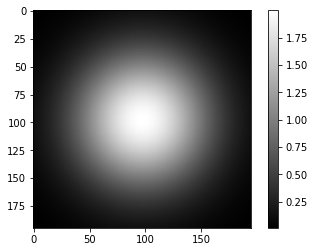

In [ ]:
plt.imshow(sigma_matrix,'gray')
plt.colorbar()
plt.show()

Let's observe images

Text(0.5, 1.0, 'Space Variant Blurred Image')

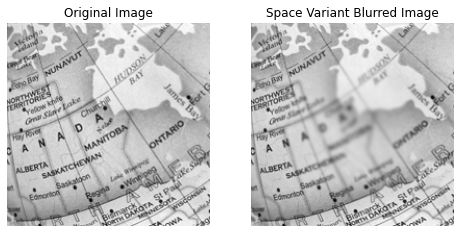

In [ ]:
#code for displaying multiple images in one figure

# create figure
fig = plt.figure(figsize=(8,5))

# setting values to rows and column variables
rows = 1
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(globe,'gray')
plt.axis('off')
plt.title("Original Image")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(blurred_image,'gray')
plt.axis('off')
plt.title("Space Variant Blurred Image")

###9. Comparison of Space Variant and Space Invariant Blur

In [ ]:
# read the image
nautilus = imread("Nautilus.png")

# get the shape of the image
[x_, y_] = np.shape(nautilus)

# sigma as given in the assignment PDF
sigma = 1.0
# constant blur matrix
sigma_matrix = sigma*np.ones((x_, y_), dtype=np.float)
# space varying blur with a constant blur matrix
blurred_1 = produce_space_variant_blur(nautilus, sigma_matrix)
# space invariant blur
blurred_2 = convolve_2D(nautilus, sigma)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.or

Performing space-varying blur...
Performing space-invariant blur for sigma=1.0...


Text(0.5, 1.0, 'Space Invariant Blur')

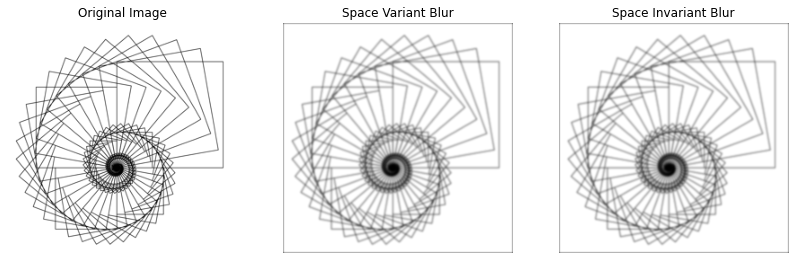

In [ ]:
#code for displaying multiple images in one figure

# create figure
fig = plt.figure(figsize=(14,8))

# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(nautilus,'gray')
plt.axis('off')
plt.title("Original Image")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(blurred_1,'gray')
plt.axis('off')
plt.title("Space Variant Blur")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(blurred_2,'gray')
plt.axis('off')
plt.title("Space Invariant Blur")

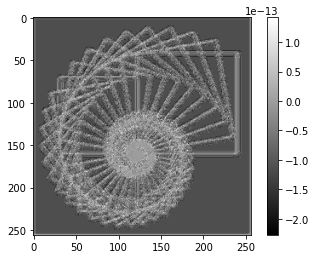

In [ ]:
diff= blurred_1-blurred_2
plt.imshow(diff,'gray')
plt.colorbar()

plt.show()

The difference is of the order $10^{-13}$ and hence can be considered as zero.


#**Observations:**

By looking at the results obtained, the following observations can be made.
* Increase in $\sigma$ results in increase in blur.
* There is no blurring when sigma is 0.
* Since Gaussian kernal is symmetric, blur_kernal can or cannot be flipped for computation of convolution. It doesnot affect the result.

* While performing space varying blur on "Globe.png", we see that maximum blurring occurs at the central region of the image and almost no blur occurs at pixels far from the center.
as $σ$ values are the highest at the center and taper off to zero as we move away from the center.

* Space varying blur is a much more computationally intensive process than space varying blur as the Gaussian Kernel needs to be calculated for each pixel.

* When the blur matrix is constant, space invariant and space varying blur give the same results. 

* Space varying blur can be made more efficient by saving the kernels already calculated.
